### 导包

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
import d2l.torch as d2l
import collections
import re

In [2]:
def read_time_mechaine():
    with open('./The Echo of a Dying Star.txt','r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]

    
def tokenize(lines,token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token=='char':
        return [list(line) for line in lines]
    else:
        print('错误，未知词元类型:'+token)

#统计词元频率
def count_conpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0],list):
        #把词元列表展平成使用词元填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [3]:
#词汇表类
class Vocab:
    def __init__(self,tokens=None,min_freq=0,reserved_token=None):
        if tokens is None:
            tokens = []
        if reserved_token is None:
            reserved_token = []
        #按照出现的频率进行排序
        counter = count_conpus(tokens)
        self.token_freqs = sorted(counter.items(),key=lambda x: x[1],reverse=True)
        #未知的词元索引为0
        self.unk,uniq_tokens = 0,['<unk>'] + reserved_token
        uniq_tokens += [token for token,freq in self.token_freqs if freq >= min_freq and tokens not in uniq_tokens]
        self.idx_to_token,self.token_to_idx = [],dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token]=len(self.idx_to_token) - 1
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self,tokens):
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [4]:
# 整合所有的功能
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器文本数据集中的词元索引和词汇表"""
    lines = read_time_mechaine()
    tokens = tokenize(lines,'char')
    vocab = Vocab(tokens)
    #把所有文本行展平到一个列表
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus,vocab

In [5]:
import random
import torch

#随机采样
def seq_data_iter_random(corpus,batch_size,num_steps):
    #考虑标签，所以-1
    num_subseqs = (len(corpus) -1) // num_steps
    #序列的起始索引
    initial_indices = list(range(random.randint(0,5),num_subseqs * num_steps,num_steps))
    print(initial_indices)
    #为了随机的效果，打乱initial_indices
    random.shuffle(initial_indices)
    def data(pos):
        return corpus[pos:pos+num_steps]
    num_batches = num_subseqs // batch_size
    for i in range(0,batch_size * num_batches,batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        #取数据
        x = [data(j) for j in initial_indices_per_batch]
        y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(x),torch.tensor(y)

#顺序采样
def seq_data_iter_sequential(corpus,batch_size,num_steps):
    #有效tokens长度
    index = random.randint(0,num_steps)
    num_tokens = ((len(corpus) - index -1) // batch_size) * batch_size
    xs = torch.tensor(corpus[index:index + num_tokens])
    ys = torch.tensor(corpus[index + 1:index + num_tokens + 1])
    #print(xs,ys)
    xs,ys = xs.reshape(batch_size,-1),ys.reshape(batch_size,-1)
    
    num_batches = xs.shape[1] // num_steps
    for i in range(0,num_steps * num_batches,num_steps):
        x = xs[:,i:i+num_steps]
        y = ys[:,i:i+num_steps]
        yield x,y

In [6]:
#把两个采样函数包装到类中，方便后续使用
class SeqDataLoader:
    def __init__(self,batch_size,num_steps,use_random_iter,max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus,self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size,self.num_steps = batch_size,num_steps
    def __iter__(self):
        return self.data_iter_fn(self.corpus,self.batch_size,self.num_steps)

In [7]:
def load_data_time_matchine(batch_size,num_steps,use_random_iter=False,max_tokens=10000):
    data_iter = SeqDataLoader(batch_size,num_steps,use_random_iter,max_tokens)
    return data_iter,data_iter.vocab

In [29]:
### 加载time_machine数据
batch_size,num_steps = 32,35
train_iter,vocab = load_data_time_matchine(batch_size=batch_size,num_steps=num_steps)

In [30]:
vocab.token_to_idx

{'<unk>': 0,
 ' ': 1,
 'e': 2,
 't': 3,
 'a': 4,
 'i': 5,
 'n': 6,
 's': 7,
 'r': 8,
 'o': 9,
 'h': 10,
 'l': 11,
 'd': 12,
 'c': 13,
 'u': 14,
 'g': 15,
 'w': 16,
 'f': 17,
 'p': 18,
 'm': 19,
 'y': 20,
 'b': 21,
 'v': 22,
 'k': 23,
 'q': 24,
 'x': 25,
 'j': 26,
 'z': 27}

In [31]:
for x,y in train_iter:
    print(x,y)
    break

tensor([[ 3,  4,  8,  ...,  3, 13, 10],
        [ 1, 12,  5,  ...,  7,  9, 14],
        [ 1,  3, 10,  ...,  2,  4,  3],
        ...,
        [14,  6,  8,  ...,  1,  5,  3],
        [ 2,  8,  1,  ...,  5,  4, 11],
        [ 6, 20,  1,  ...,  6, 12,  1]]) tensor([[ 4,  8,  5,  ..., 13, 10,  2],
        [12,  5,  7,  ...,  9, 14,  6],
        [ 3, 10,  2,  ...,  4,  3,  5],
        ...,
        [ 6,  8,  4,  ...,  5,  3,  7],
        [ 8,  1, 11,  ...,  4, 11,  1],
        [20,  1, 17,  ..., 12,  1, 13]])


In [11]:
x.shape

torch.Size([32, 35])

In [12]:
y.shape

torch.Size([32, 35])

In [13]:
#输入数据，我们打算输入one_hot编码的数据
# pytorch 提供快速进行one_hot编码的工具
F.one_hot(torch.tensor([0,2]),num_classes=len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [14]:
x = torch.arange(10).reshape((2,5))

In [15]:
x = F.one_hot(x.T,28)

In [16]:
x.shape

torch.Size([5, 2, 28])

### 初始化模型参数

In [17]:
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape,device = device) * 0.01
    #隐藏层参数
    w_xh = normal((num_inputs,num_hiddens))
    w_hh = normal((num_hiddens,num_hiddens))
    b_h = torch.zeros(num_hiddens,device=device)
    #输出层参数
    w_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)

    # nn.parameter(w_xh)
    #把这些参数都设置requires_grad=True
    params = [w_xh,w_hh,b_h,w_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [18]:
get_params(28,512,'cuda:0')

[tensor([[-0.0083, -0.0108, -0.0060,  ..., -0.0108, -0.0090, -0.0035],
         [-0.0037,  0.0028, -0.0052,  ..., -0.0093, -0.0087, -0.0009],
         [ 0.0032,  0.0068, -0.0064,  ...,  0.0034, -0.0003,  0.0004],
         ...,
         [ 0.0101,  0.0201,  0.0034,  ..., -0.0019,  0.0064, -0.0095],
         [ 0.0088,  0.0008,  0.0088,  ..., -0.0018, -0.0055, -0.0099],
         [ 0.0235, -0.0013,  0.0070,  ..., -0.0048, -0.0134,  0.0059]],
        device='cuda:0', requires_grad=True),
 tensor([[-0.0020, -0.0189,  0.0059,  ..., -0.0056, -0.0052, -0.0131],
         [ 0.0022, -0.0049,  0.0038,  ..., -0.0064,  0.0045, -0.0062],
         [-0.0038, -0.0021, -0.0135,  ..., -0.0089, -0.0073, -0.0139],
         ...,
         [ 0.0018, -0.0107,  0.0134,  ..., -0.0061,  0.0008, -0.0129],
         [ 0.0124,  0.0178,  0.0194,  ...,  0.0024, -0.0009, -0.0130],
         [-0.0086,  0.0072,  0.0127,  ...,  0.0246, -0.0061, -0.0071]],
        device='cuda:0', requires_grad=True),
 tensor([0., 0., 0., 0., 0

In [19]:
# 初始化时返回隐藏状态
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device =device),)

In [20]:
# rnn主体结构 循环神经网络
def rnn(inputs,state,params):
    #inputs的形状（时间步数据量，批次大小，词表大小）
    w_xh,w_hh,b_h,w_hq,b_q = params
    H, = state
    outputs = []
    #x的shape:[批次大小，词表大小]
    for x in inputs:
        #一般在循环神经网络中激活函数用tanh
        H = torch.tanh(torch.mm(x,w_xh) + torch.mm(H,w_hh) + b_h)
        #display(H.shape,w_hq.shape,b_q.shape)
        Y = torch.mm(H,w_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

In [21]:
t1 = torch.zeros((2,10))
t2 = torch.ones((2,10))
display(t1,t2)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [22]:
t_outputs = []
t_outputs.append(t1)
t_outputs.append(t2)

In [23]:
t_outputs

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])]

In [24]:
torch.cat(t_outputs,dim=0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [25]:
#包装成类
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forwaed_fn):
        self.vocab_size,self.num_hiddens = vocab_size,num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forwaed_fn = init_state,forwaed_fn
    def __call__(self,X,state):
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forwaed_fn(X,state,self.params)
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [32]:
#试用一下
num_hiddens = 512
net = RNNModelScratch(len(vocab),num_hiddens,device,get_params,init_rnn_state,rnn)
state = net.begin_state(x.shape[0],device)
Y,new_state = net(x.to(device),state)

In [33]:
Y.shape

torch.Size([1120, 28])

In [34]:
new_state[0].shape

torch.Size([32, 512])

In [67]:
# 预测
def predict(prefix,num_preds,net,vocab,device):
    state = net.begin_state(batch_size=1,device=device)
    outputs = [vocab[prefix[0]]]

    get_input = lambda : torch.tensor([outputs[-1]],device=device).reshape((1,1))
    #预热
    for u in prefix[1:]:
        #print(get_input())
        _,state = net(get_input(),state)
        outputs.append(vocab[u])
    #真正预测
    for _ in range(num_preds):
        y,state = net(get_input(),state)
        #print('真正预测:',y)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [36]:
predict('n the year',10,net,vocab,device)

outputs: 6
tensor([[6]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[10]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[20]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[4]], device='cuda:0')


'n the yearnflkqukquk'

In [62]:
# 梯度裁剪
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [63]:
#训练
def train_epoch(net,train_iter,loss,updater,device,use_random_iter):
    state,timer = None,d2l.Timer()
    metric = d2l.Accumulator(2)
    #取数据
    for X,Y in train_iter:
        if state is None or use_random_iter:
            #第一次训练或者使用随机抽样时，都需要把state重新初始化
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            #梯度释放
            if isinstance(net,nn.Module) and not isinstance(state,tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X,y = X.to(device),y.to(device)
        y_hat,state = net(X,state)
        l = loss(y_hat,y.long()).mean()
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # rnn容易梯度爆炸 使用梯度裁剪
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        #print(l,y.numel())   
        metric.add(l * y.numel(), y.numel())
    #返回困惑度和每个字符平均的时间
    return math.exp(metric[0] / metric[1]),metric[1] / timer.stop()

In [69]:
#组合到一起
def train(net,train_iter,vocab,lr,num_epochs,device,use_random_iter=False):
    loss = nn.CrossEntropyLoss() #交叉熵损失函数
    animator = d2l.Animator(xlabel='epoch',ylabel='perlexity',legend=['train'],xlim=[10,num_epochs])
    #初始化
    if isinstance(net,nn.Module):
        updater = torch.optim.SGD(net.parameters(),lr)
    else:
        print('加载自定义的网络')
        updater = lambda batch_size:d2l.sgd(net.params,lr,batch_size)
    pred = lambda prefix:predict(prefix,50,net,vocab,device)
    #训练and forcast
    for epoch in range(num_epochs):
        ppl,speed = train_epoch(net,train_iter,loss,updater,device,use_random_iter)
        if (epoch + 1) % 10 ==0:
            print(pred("It wasn't a sound"))
            animator.add(epoch + 1,[ppl])
    print(f'困惑度{ppl:.1f},{speed:.1f}词元/秒{str(device)}')
    print(pred("It wasn't a sound"))
    print(pred(" a sound"))

困惑度1.1,17649.6词元/秒cuda:0
<unk>t wasn<unk>t a sound but a ripple faint gravitational whisper etched i
 a soundey s lof che serras urn a tarn al yomerd cherate f


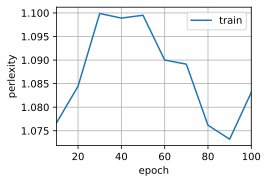

In [71]:
num_epochs, lr = 100, 0.01
# 使用顺序抽样
train(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())